In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
from scipy.misc import derivative
import scipy.integrate as intg


In [3]:
file = '../data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
# data.describe()
data

,z,$f\sigma_8$,err
0,0.020,0.4280,0.0465
1,0.020,0.3980,0.0650
2,0.020,0.3140,0.0480
3,0.100,0.3700,0.1300
4,0.150,0.4900,0.1450
5,0.170,0.5100,0.0600
6,0.180,0.3600,0.0900
7,0.380,0.4400,0.0600
8,0.250,0.3512,0.0583
9,0.370,0.4602,0.0378


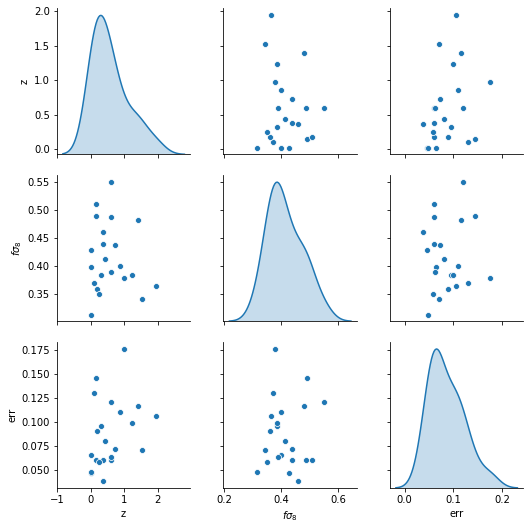

In [4]:
sns.pairplot(data, diag_kind="kde")
# plt.savefig("Distfs8.png")

In [5]:
# a= np.array([12,4,2,7,14,11,20,16,9,19,5,17,1,15,10,8,18,21,0,13,3,6])
# a = np.array([21,1,3,10,12,17,8,4,7,16, 2,11,19,13,18,5,9,20,15,14,6,0])
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
even = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(even)
# randomize = np.random.permutation(len(data.values))
data = data.values[shuffle]
# array([17, 10,  1, 19, 12,  8, 14, 18,  4,  3,  6,  9, 21, 16,  2, 15,  0,
#        20,  7,  5, 11, 13])
# array([ 1, 15, 12, 20, 21,  3, 18, 13,  7, 19,  9,  8, 14,  6, 11,  4,  0,
#         5,  2, 10, 16, 17])

Read the data for cosmic chronometers

In [6]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [7]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [8]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [9]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=10)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()

In [10]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
    ehidden2 = Dense(50, activation='relu')(ehidden)
    elast = Dense(2, activation='relu')(ehidden2)
    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 7,902
Trainable params: 7,902
Non-trainable params: 0
_________________________________________________________________


In [11]:
# batch_size = 4
batch_size = 4
input_z = Input(shape = (1,))
epochs = 100

In [12]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0925 - val_loss: 0.0802
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0917 - val_loss: 0.0799
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0916 - val_loss: 0.0795
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0914 - val_loss: 0.0792
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0914 - val_loss: 0.0791
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0913 - val_loss: 0.0792
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0913 - val_loss: 0.0791
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0915 - val_loss: 0.0791
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0913 - val_loss: 0.0792
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0914 - val_loss: 0.0792
Epoch 11/100
5/5 [==========

5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 85/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 86/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 87/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 88/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 89/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 90/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0055
Epoch 91/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 92/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 93/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 94/100
5/5 [===============

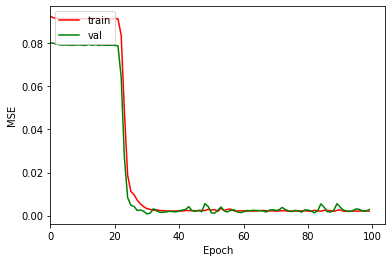

In [31]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("loss_fs8.png", dpi=200)
# plt.savefig("loss_epochs_fs8_1000.png", dpi=200)


In [14]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])
# 0.0008741355268284677, 0.0022569920402020216) 20 ep
# (0.0009615894523449242, 0.001980467466637492) 100
# (0.0008648062357679009, 0.0017015849007293582) 500 ep


(0.0007881031488068401, 0.0020000021904706955)

In [15]:
pred = neural_model.predict(z_test)
pred

array([[0.45428208, 0.06548477],
       [0.48118964, 0.09480427],
       [0.46756375, 0.09662739],
       [0.45866677, 0.1032099 ],
       [0.41909373, 0.10931371]], dtype=float32)

In [16]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [17]:
ranz = np.random.uniform(0, 2, size=10000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


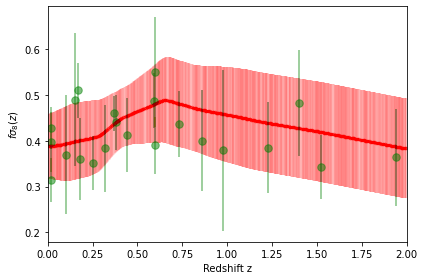

In [32]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.xlabel("Redshift z")
plt.ylabel("$f\sigma_8(z)$")
plt.xlim(0, 2)
plt.tight_layout()
# plt.legend()
# plt.savefig("synthetic_fs8_100.png")

In [19]:
# Cosmological constants
Om = 0.27
# variance network
s8 = 0.8

In [20]:
def Ezlcdm(a):
    return np.sqrt(Om*(1/a)**3 + 1 - Om)


# returns the growth factor as a function of redshift
def GrowthIntegrand_a(a):
    return 1./(self.RHSquared_a(a)*a*a)**(1.5)


def growth(z):
    # Equation 7.77 from Doddie
    af = 1/(1.+z)
    r = intg.quad(GrowthIntegrand_a, 1e-7, af)
    gr = sp.sqrt(Ezlcdm(af))*r[0]  # assume precision is ok
    # If we have Omega_m, let's normalize that way
    gr *= 5/2.*Om
    return gr


def fs8(z):
    return -s8*(1+z)*derivative(growth, z, dx=1e-6)/growth(0)

In [21]:
# z = np.linspace(0, 2, 10000)
# plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)

# plt.plot(z, fs8(z), label='$\Lambda CDM$', c='b')
# plt.xlabel("Redshift z")
# plt.ylabel("$f\sigma_8(z)$")
# plt.xlim(0, 2)
# plt.tight_layout()
# plt.legend()

# plt.savefig("Syntheticfs8.png",dpi=800)

In [22]:
pred_random.shape, r.shape

((10000, 2), (10000, 1))

In [23]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,50)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [24]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)


# np.savetxt("annfs850.dat",mookHz, delimiter=" ")

In [25]:
mookHz

array([[0.59022878, 0.47936779, 0.0843597 ],
       [1.76133966, 0.40115085, 0.10933723],
       [1.44994659, 0.42429253, 0.10890422],
       [1.4968225 , 0.4211334 , 0.10914366],
       [0.81567841, 0.47160995, 0.0943806 ],
       [1.7656695 , 0.40082037, 0.10933714],
       [1.05189399, 0.45325443, 0.10587419],
       [0.09263535, 0.39331415, 0.08036946],
       [0.8809215 , 0.46589139, 0.09791937],
       [1.19899293, 0.4411377 , 0.10791776],
       [0.428881  , 0.45267865, 0.06496224],
       [0.68525235, 0.48686835, 0.09536473],
       [0.35964712, 0.43454596, 0.06886118],
       [1.27710288, 0.43575615, 0.10818757],
       [0.84141342, 0.46927053, 0.09539125],
       [1.19899293, 0.4411377 , 0.10791776],
       [0.17082836, 0.4005439 , 0.08375172],
       [0.0753782 , 0.39188859, 0.0786522 ],
       [1.14123472, 0.44558367, 0.10781076],
       [0.48134211, 0.46183315, 0.0689455 ],
       [1.52670729, 0.41904292, 0.10931768],
       [1.43917663, 0.42500684, 0.10885976],
       [1.

In [26]:
predy_reduced[:,1]

array([0.0843597 , 0.10933723, 0.10890422, 0.10914366, 0.0943806 ,
       0.10933714, 0.10587419, 0.08036946, 0.09791937, 0.10791776,
       0.06496224, 0.09536473, 0.06886118, 0.10818757, 0.09539125,
       0.10791776, 0.08375172, 0.0786522 , 0.10781076, 0.0689455 ,
       0.10931768, 0.10885976, 0.10933714, 0.10933992, 0.10933614,
       0.10736182, 0.09105728, 0.10933549, 0.06492092, 0.10292961,
       0.10797465, 0.10933959, 0.07968817, 0.10862101, 0.10933737,
       0.10844874, 0.10920467, 0.09492217, 0.08312356, 0.10165538,
       0.10915472, 0.10831063, 0.10847998, 0.07373028, 0.10781048,
       0.10781048, 0.08391991, 0.09532917, 0.10933519, 0.07081477],
      dtype=float32)

In [27]:
error  = predy_reduced[:,1]**2
error

array([0.00711656, 0.01195463, 0.01186013, 0.01191234, 0.0089077 ,
       0.01195461, 0.01120934, 0.00645925, 0.0095882 , 0.01164624,
       0.00422009, 0.00909443, 0.00474186, 0.01170455, 0.00909949,
       0.01164624, 0.00701435, 0.00618617, 0.01162316, 0.00475348,
       0.01195036, 0.01185045, 0.01195461, 0.01195522, 0.01195439,
       0.01152656, 0.00829143, 0.01195425, 0.00421473, 0.0105945 ,
       0.01165853, 0.01195515, 0.0063502 , 0.01179852, 0.01195466,
       0.01176113, 0.01192566, 0.00901022, 0.00690953, 0.01033382,
       0.01191475, 0.01173119, 0.01176791, 0.00543615, 0.0116231 ,
       0.0116231 , 0.00704255, 0.00908765, 0.01195418, 0.00501473],
      dtype=float32)

In [28]:
diagcov = np.diag(error) #inverso
# np.savetxt("annfs8_cov50.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(50, 50)

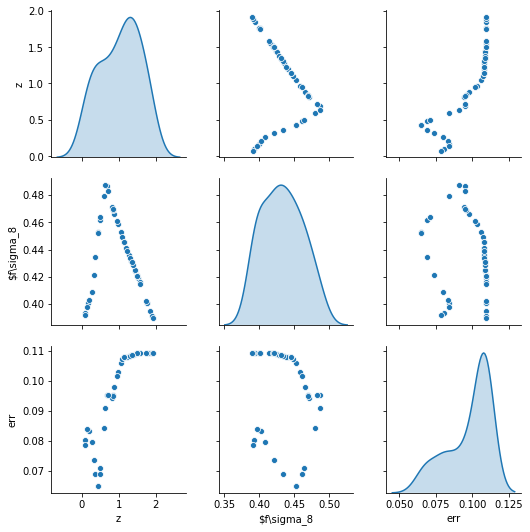

In [29]:
dfMook = pd.DataFrame(mookHz, columns=['z', '$f\sigma_8', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("dist50fs8fake.png")